## **Importing Required libraries**

In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 48.8 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.4 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=291653 sha256=ee29c5789ad9a970709edbe40ec08ccc2441449121af8fd6db852b872d3d0970
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)



## **Creating function to Extract Data**

In [3]:

def extract_stock_data(stock_ticker, start_date, end_date):
    """
    Extracts stock data using yfinance.

    :param stock_ticker: Stock symbol to query
    :param start_date: Start date of the data in 'YYYY-MM-DD' format
    :param end_date: End date of the data in 'YYYY-MM-DD' format
    :return: Pandas DataFrame containing stock data
    """
    stock_data = yf.download(stock_ticker, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    return stock_data


In [4]:
df = extract_stock_data('TSLA', '2020-01-01', '2024-01-01')

[*********************100%%**********************]  1 of 1 completed


## **Preprocessing Steps**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1006 non-null   datetime64[ns]
 1   Open       1006 non-null   float64       
 2   High       1006 non-null   float64       
 3   Low        1006 non-null   float64       
 4   Close      1006 non-null   float64       
 5   Adj Close  1006 non-null   float64       
 6   Volume     1006 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 55.1 KB


### Check for NULL and Duplicate

In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df.duplicated().sum()

0

# **EDA**

### Trend Analysis

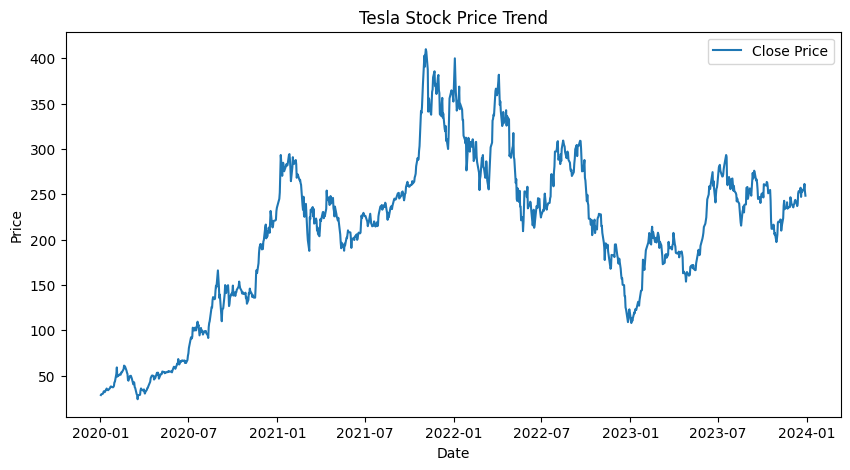

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

# Trend Analysis
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('Tesla Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

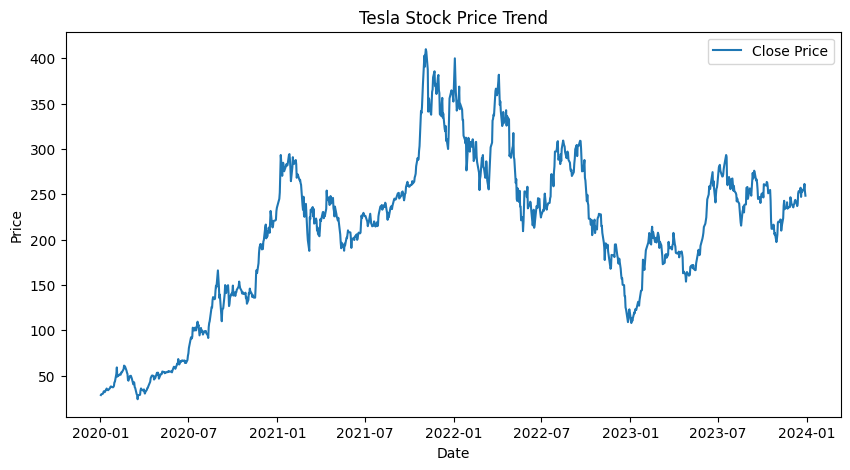

In [9]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Date', y='Close', label='Close Price')
plt.title('Tesla Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Volatility Analysis

In [10]:
# Volatility Analysis
df['Returns'] = df['Close'].pct_change()
volatility = df['Returns'].std() * np.sqrt(252)
print(f'Annualized Volatility: {volatility * 100:.2f}%')

Annualized Volatility: 68.10%


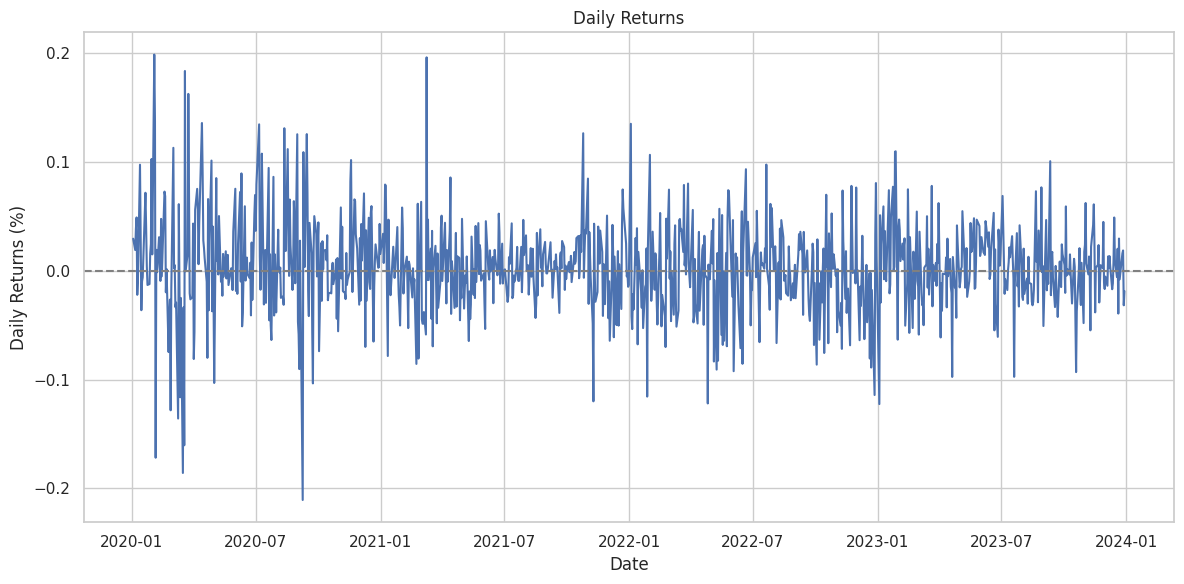

In [11]:
# Plotting the returns using Seaborn's lineplot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Returns', data=df).set_title('Daily Returns')

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color='grey', linestyle='--')

# Improving plot aesthetics
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

plt.show()

### Moving Averages

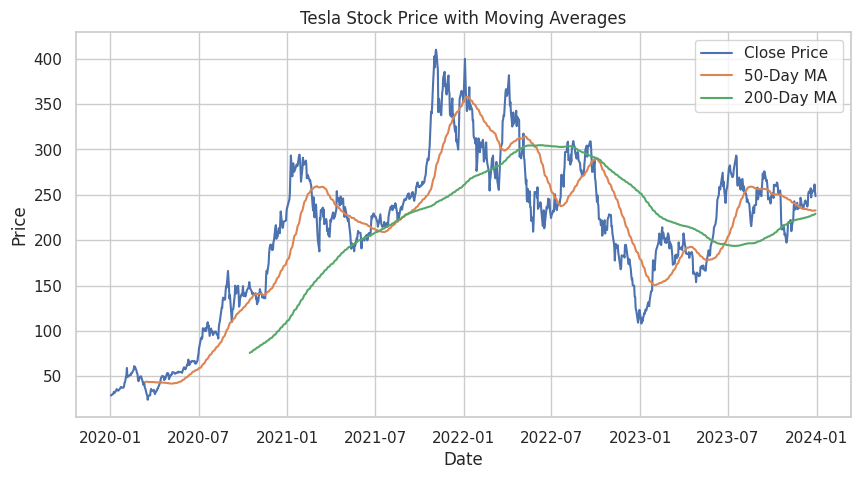

In [12]:
# Moving Averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x='Date', y='Close', data=df, label='Close Price')
sns.lineplot(x='Date', y='MA50', data=df, label='50-Day MA')
sns.lineplot(x='Date', y='MA200', data=df,label='200-Day MA')
plt.title('Tesla Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Momentum Indicators: RSI

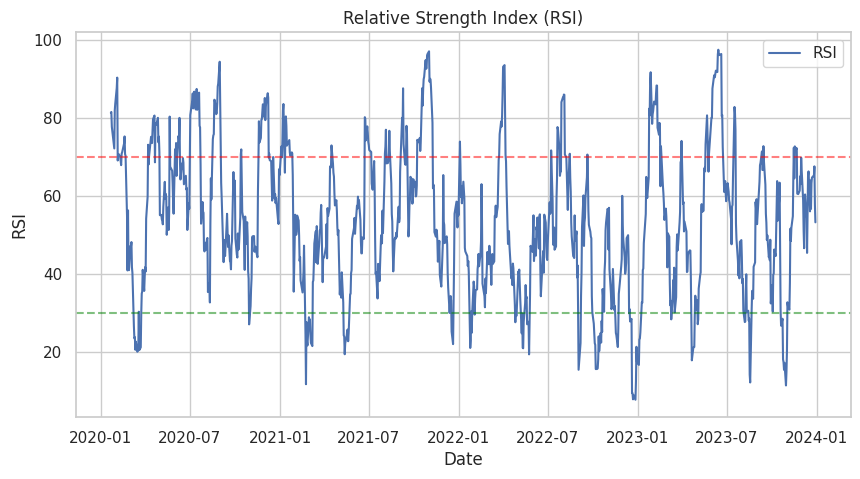

In [13]:
# Momentum Indicators: RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['Close'])
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Date', y='RSI', label='RSI')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.legend()
plt.show()


### Volume Analysis

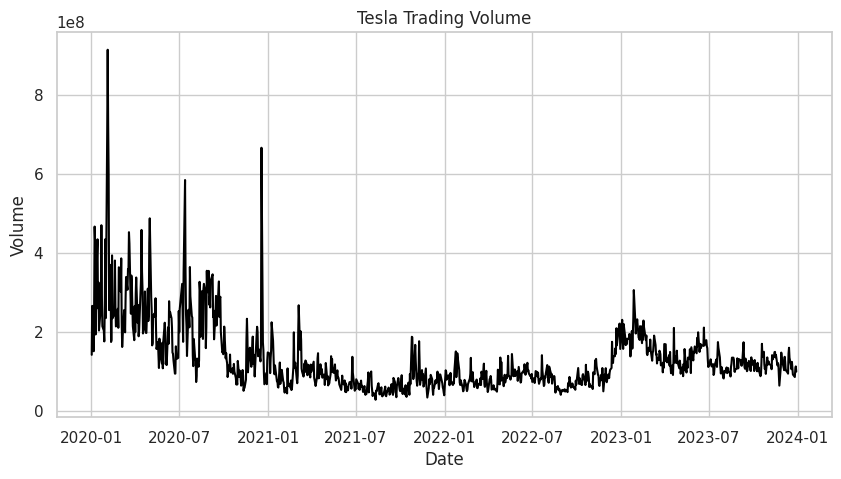

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Volume'], color='black')
plt.title('Tesla Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


## Predictive Modeling using OLS and RLM

In [17]:
# Predictive Modeling: Simple Linear Regression
# Using 'Close' as the dependent variable and 'Open', 'High', 'Low', 'Volume' as independent variables
X = df[['Open', 'High', 'Low', 'Volume']]
y = df['Close']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Building and fitting the Ordinary Least Squares (OLS) model
ols_model = sm.OLS(y, X).fit()
# Making predictions with the OLS model
ols_predictions = ols_model.predict(X)

# Building and fitting the Robust Linear Model (RLM)
rlm_model = sm.RLM(y, X).fit()
# Making predictions with the RLM
rlm_predictions = rlm_model.predict(X)


In [18]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.964e+05
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:31:30   Log-Likelihood:                -2552.3
No. Observations:                1006   AIC:                             5115.
Df Residuals:                    1001   BIC:                             5139.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0965      0.493      0.196      0.8

In [19]:
print(rlm_model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                  Close   No. Observations:                 1006
Model:                            RLM   Df Residuals:                     1001
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 14 Apr 2024                                         
Time:                        19:31:44                                         
No. Iterations:                    46                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1789      0.415      0.431      0.6

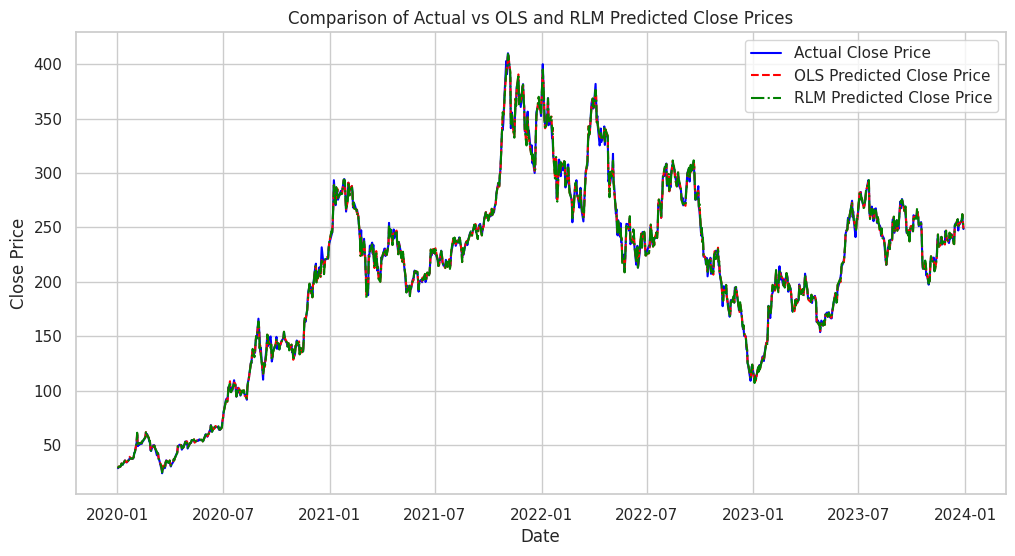

In [20]:

# Plotting the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Actual Close Price', color='blue')
plt.plot(df['Date'], ols_predictions, label='OLS Predicted Close Price', color='red', linestyle='--')
plt.plot(df['Date'], rlm_predictions, label='RLM Predicted Close Price', color='green', linestyle='-.')
plt.title('Comparison of Actual vs OLS and RLM Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

To Visualize better we are plotting for only last 20 days

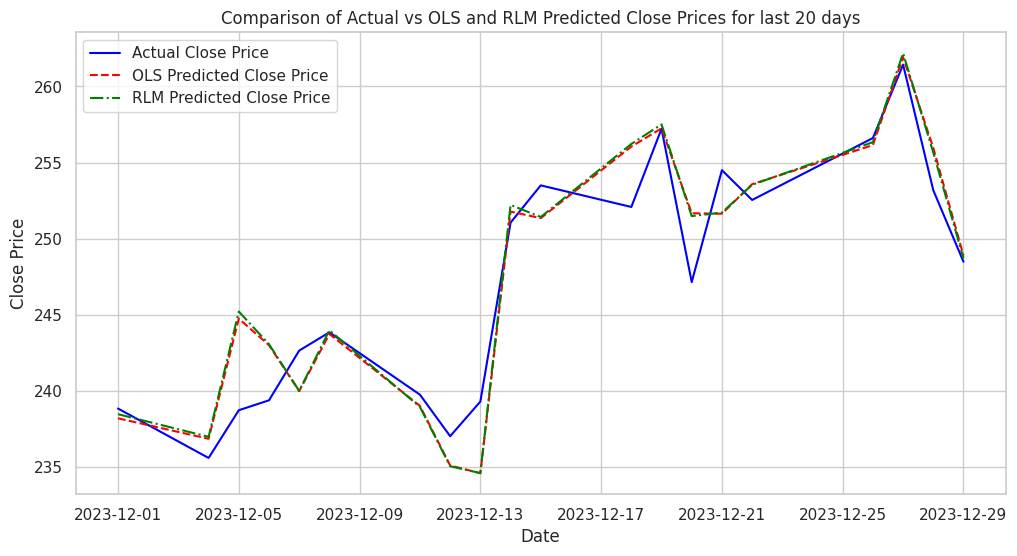

In [21]:

last_df = df.tail(20)
last_ols_predictions = ols_predictions.tail(20)
last_rlm_predictions = rlm_predictions.tail(20) 
# Plotting the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(last_df['Date'], last_df['Close'], label='Actual Close Price', color='blue')
plt.plot(last_df['Date'], last_ols_predictions, label='OLS Predicted Close Price', color='red', linestyle='--')
plt.plot(last_df['Date'], last_rlm_predictions, label='RLM Predicted Close Price', color='green', linestyle='-.')
plt.title('Comparison of Actual vs OLS and RLM Predicted Close Prices for last 20 days')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation Metrics

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

ols_mae = mean_absolute_error(y, ols_predictions)
ols_mse = mean_squared_error(y, ols_predictions)
ols_rmse = np.sqrt(ols_mse)
ols_r2 = r2_score(y, ols_predictions)

print(f"OLS MAE: {ols_mae}")
print(f"OLS MSE: {ols_mse}")
print(f"OLS RMSE: {ols_rmse}")
print(f"OLS R-squared: {ols_r2}")

rlm_mae = mean_absolute_error(y, rlm_predictions)
rlm_mse = mean_squared_error(y, rlm_predictions)
rlm_rmse = np.sqrt(rlm_mse)
rlm_r2 = r2_score(y, rlm_predictions)

print(f"OLS MAE: {rlm_mae}")
print(f"OLS MSE: {rlm_mse}")
print(f"OLS RMSE: {rlm_rmse}")
print(f"OLS R-squared: {rlm_r2}")

OLS MAE: 2.1815812652790947
OLS MSE: 9.358026012249542
OLS RMSE: 3.0590890821042698
OLS R-squared: 0.9987274787179654
OLS MAE: 2.162383536427512
OLS MSE: 9.454717700505501
OLS RMSE: 3.0748524680877782
OLS R-squared: 0.9987143304075268


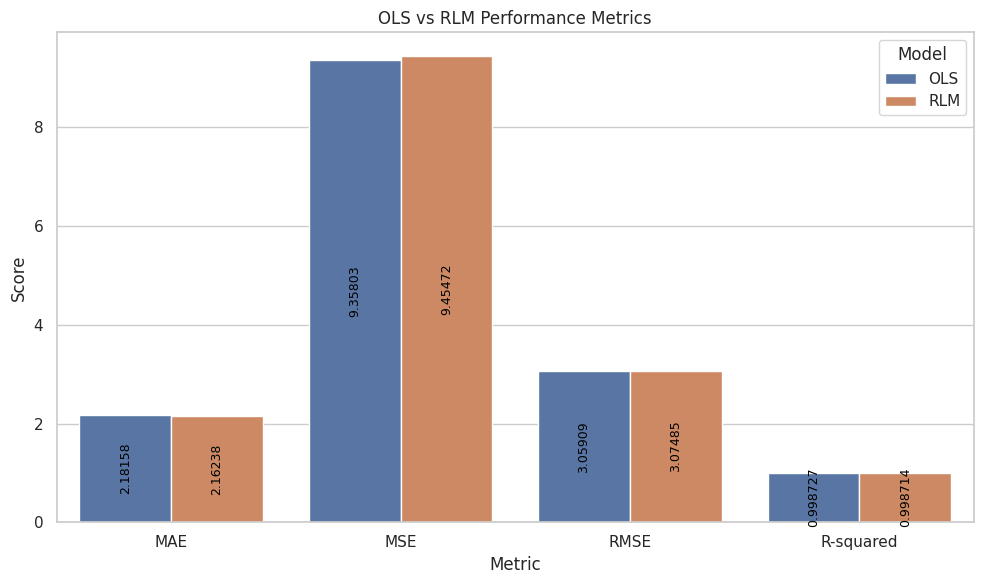

In [23]:
# Metrics and their values for plotting
metrics = ['MAE', 'MSE', 'RMSE', 'R-squared']
ols_values = [ols_mae, ols_mse, ols_rmse, ols_r2]
rlm_values = [rlm_mae, rlm_mse, rlm_rmse, rlm_r2]


data = pd.DataFrame({
    'Metric': metrics * 2,
    'Score': ols_values + rlm_values,
    'Model': ['OLS'] * len(metrics) + ['RLM'] * len(metrics)
})

# Create a barplot with Seaborn
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Metric', y='Score', hue='Model', data=data, ci=None)

# Add the numeric data on top of each bar
for container in barplot.containers:
    barplot.bar_label(container, label_type='center', rotation=90, color='black', fontsize=9)

plt.title('OLS vs RLM Performance Metrics')
plt.tight_layout()
plt.show()

plt.show()